### Algorytmy Macierzowe lab 2

#### Konfiguracja

In [88]:
import numpy as np
import scipy.linalg
from math import log, ceil, pow
from typing import Tuple, List

#### Generowanie macierzy

In [89]:
def generate_matrix(ncols: int, nrows: int):
    return np.random.uniform(low=0.00000001, high=1.0, size=(nrows, ncols))

#### Licznik operacji

In [90]:
class Counter:
    def __init__(self) -> None:
        self.add_counter = 0
        self.mul_counter = 0
        self.div_counter = 0
        self.sub_counter = 0
        self.operation_counter = 0

    def add(self, A: np.ndarray, B: np.ndarray) -> np.ndarray:
        self.add_counter += A.size
        self.operation_counter += A.size
        return A + B

    def mul(self, A: np.ndarray, B: np.ndarray) -> np.ndarray:
        self.mul_counter += 1
        self.operation_counter += int(
            (A.shape[0]) ** 2.807
        )  # we assume Strassen algorithm for multiplication
        return A @ B

    def inc_flops_mul(self, count: int):
        self.operation_counter += count

    def print_counters(self) -> None:
        print(f"Number of add operations: {self.add_counter}")
        print(f"Number of sub operations: {self.sub_counter}")
        print(f"Number of div operations: {self.div_counter}")
        print(f"Number of mul operations: {self.mul_counter}")
        print(f"Number of unit operations: {self.operation_counter}")

#### Funckje pomocniczne

In [91]:
def resize_matrix_to_2n(A: np.ndarray):
    """Change size of matrix to simplify processing"""
    size_A = A.shape
    new_height: int = 0
    new_width: int = 0

    new_height = find_next_power_of_2(size_A[0])

    new_width = find_next_power_of_2(size_A[1])

    new_A = np.pad(
        A, [(0, new_height - size_A[0]), (0, new_width - size_A[1])], mode="constant"
    )

    return new_A


def split(array: np.ndarray, n: int) -> Tuple:
    """Split a matrix into sub-matrices"""
    return (
        array[:n, :n],
        array[:n, n:],
        array[n:, :n],
        array[n:, n:],
    )


def find_next_power_of_2(number: int) -> int:
    """Finds closest number that is power of 2"""
    return int(pow(2, ceil(log(number) / log(2))))

#### Rekurencyjne odwracanie macierzy

In [92]:
A = generate_matrix(5, 5)


def recursive_matrix_inverse(A: np.ndarray, counter: Counter) -> np.ndarray:
    add = counter.add

    mul = counter.mul
    if A.size > 1:
        split_at = A.shape[0] // 2
        A11, A12, A21, A22 = split(A, split_at)

        A11_inv = recursive_matrix_inverse(A11, counter)
        S22 = add(A22, -mul(mul(A21, A11_inv), A12))
        S22_inv = recursive_matrix_inverse(S22, counter)

        B11 = mul(
            A11_inv,
            add(np.identity(A11.shape[0]), mul(mul(mul(A12, S22_inv), A21), A11_inv)),
        )
        B12 = -mul(mul(A11_inv, A12), S22_inv)
        B21 = -mul(mul(S22_inv, A21), A11_inv)
        B22 = S22_inv

        return np.concatenate(
            [np.concatenate([B11, B12], axis=1), np.concatenate([B21, B22], axis=1)],
            axis=0,
        )
    else:
        return np.full((1, 1), 1 / A[0][0])

counter = Counter()
print(recursive_matrix_inverse(A.copy(), counter))
counter.print_counters()
print()
print(np.linalg.inv(A))

[[-12.99878694  -5.14057476  -4.49655008  10.08531568  13.27167065]
 [ -5.06040816  -3.50436526  -5.33350109   8.02920954   7.20328607]
 [  0.68628311  -0.17230468   1.92317126  -0.74931728  -1.80573913]
 [  4.21621105   0.27402602   2.28193652  -3.42677638  -3.4255974 ]
 [  7.30884488   4.853924     3.1531866   -7.29560354  -7.81845845]]
Number of add operations: 22
Number of sub operations: 0
Number of div operations: 0
Number of mul operations: 40
Number of unit operations: 192

[[-12.99878694  -5.14057476  -4.49655008  10.08531568  13.27167065]
 [ -5.06040816  -3.50436526  -5.33350109   8.02920954   7.20328607]
 [  0.68628311  -0.17230468   1.92317126  -0.74931728  -1.80573913]
 [  4.21621105   0.27402602   2.28193652  -3.42677638  -3.4255974 ]
 [  7.30884488   4.853924     3.1531866   -7.29560354  -7.81845845]]


In [93]:
def recursive_matrix_inverse(A: np.ndarray, counter: Counter) -> np.ndarray:
    add = counter.add

    mul = counter.mul
    if A.size > 1:
        split_at = A.shape[0] // 2
        A11, A12, A21, A22 = split(A, split_at)

        A11_inv = recursive_matrix_inverse(A11, counter)
        S22 = add(A22, -mul(mul(A21, A11_inv), A12))
        S22_inv = recursive_matrix_inverse(S22, counter)

        B11 = mul(
            A11_inv,
            add(np.identity(A11.shape[0]), mul(mul(mul(A12, S22_inv), A21), A11_inv)),
        )
        B12 = -mul(mul(A11_inv, A12), S22_inv)
        B21 = -mul(mul(S22_inv, A21), A11_inv)
        B22 = S22_inv

        return np.concatenate(
            [np.concatenate([B11, B12], axis=1), np.concatenate([B21, B22], axis=1)],
            axis=0,
        )
    else:
        return np.full((1, 1), 1 / A[0][0])

#### Rekurencyjna LU faktoryzacja

In [94]:
np.random.seed(42)
A = generate_matrix(5, 5)


def recursive_lu(A: np.ndarray, counter: Counter) -> Tuple[np.ndarray, np.ndarray]:
    add = counter.add
    mul = counter.mul
    if A.size > 1:
        split_at = A.shape[0] // 2
        A11, A12, A21, A22 = split(A, split_at)

        L11, U11 = recursive_lu(A11, counter)
        U11_inv = recursive_matrix_inverse(U11, counter)

        L21 = mul(A21, U11_inv)
        L11_inv = recursive_matrix_inverse(L11, counter)

        U12 = mul(L11_inv, A12)
        L22 = add(A22, -mul(mul(mul(A21, U11_inv), L11_inv), A12))

        Ls, Us = recursive_lu(L22, counter)
        U22 = Us
        L22 = Ls

        return np.concatenate(
            [
                np.concatenate([L11, np.full((L21.shape[1], L21.shape[0]), 0)], axis=1),
                np.concatenate([L21, L22], axis=1),
            ],
            axis=0,
        ), np.concatenate(
            [
                np.concatenate([U11, U12], axis=1),
                np.concatenate([np.full((U12.shape[1], U12.shape[0]), 0), U22], axis=1),
            ],
            axis=0,
        )
    else:
        return np.full((1, 1), 1), np.full((1, 1), A[0, 0])


counter = Counter()
print(f"Original matrix A:\n{A}\n")
L, U = recursive_lu(A, counter)
print(f"L:\n{L}\nU:\n{U}\n\nL*U=\n{L @ U}\n\n")
counter.print_counters()
print()
L, U = scipy.linalg.lu(A, permute_l=True)
print(f"Scipy L*U=\n{L @ U}")

Original matrix A:
[[0.37454013 0.95071431 0.73199394 0.59865849 0.15601865]
 [0.15599453 0.05808362 0.86617615 0.60111502 0.70807258]
 [0.0205845  0.96990985 0.83244264 0.21233912 0.18182498]
 [0.18340452 0.30424225 0.52475644 0.43194502 0.29122915]
 [0.6118529  0.13949387 0.29214466 0.36636185 0.45606999]]

L:
[[  1.           0.           0.           0.           0.        ]
 [  0.41649617   1.           0.           0.           0.        ]
 [  0.05495941  -2.71588996   1.           0.           0.        ]
 [  0.48967922   0.47738928  -0.04387629   1.           0.        ]
 [  1.63361108   4.1836794   -1.40373424 -23.74302445   1.        ]]
U:
[[ 0.37454013  0.95071431  0.73199394  0.59865849  0.15601865]
 [ 0.         -0.33788525  0.56130347  0.35177605  0.64309141]
 [ 0.          0.          2.31665115  1.13482223  1.91981579]
 [ 0.          0.          0.          0.02065207 -0.0079405 ]
 [ 0.          0.          0.          0.          0.01708756]]

L*U=
[[0.37454013 0.95071

#### Rekurencyjny wyznacznik macierzy

In [95]:
import functools
np.random.seed(42)
A = generate_matrix(5, 5)


def recursive_determinant(A: np.ndarray, counter: Counter) -> float:
    _, U = recursive_lu(A, counter)

    U_diag = np.diagonal(U)

    det = functools.reduce(lambda x, y: x * y, U_diag)
    counter.inc_flops_mul(U_diag.size - 1) # wykonaliśmy N - 1 mnożeń floatów

    return det

counter = Counter()
print(recursive_determinant(A, counter))
counter.print_counters()
print()
print(np.linalg.det(A))

-0.00010345989814896572
Number of add operations: 19
Number of sub operations: 0
Number of div operations: 0
Number of mul operations: 40
Number of unit operations: 168

-0.00010345989814893705


In [106]:
import matplotlib.pyplot as plt
from time import time
from matplotlib.ticker import FormatStrFormatter


times: List[float] = []
flops: List[int] = []

power_basis = list(range(1, 14))
powers = [2**k for k in power_basis]
print(powers)

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]


#### Wykresy

In [99]:
times_inverse: List[float] = []
flops_inverse: List[int] = []

for k in power_basis:
    A = generate_matrix(2**k, 2**k)

    counter = Counter()
    start_time: float = time()

    recursive_matrix_inverse(A, counter)

    total_time: float = time() - start_time

    times_inverse.append(total_time)
    flops_inverse.append(counter.operation_counter)

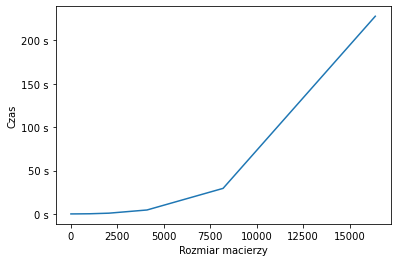

In [ ]:
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%d s"))
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas")
plt.plot(powers, times_inverse)

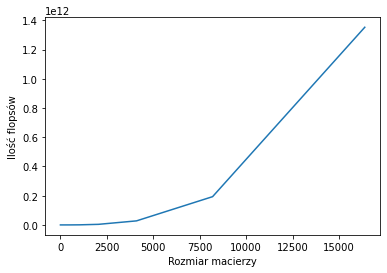

In [ ]:
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Ilość flopsów")
plt.plot(powers, flops_inverse)

In [105]:
times_lu: List[float] = []
flops_lu: List[int] = []

for k in power_basis:
    A = generate_matrix(2**k, 2**k)

    counter = Counter()
    start_time: float = time()

    recursive_lu(A, counter)

    total_time: float = time() - start_time

    times_lu.append(total_time)
    flops_lu.append(counter.operation_counter)

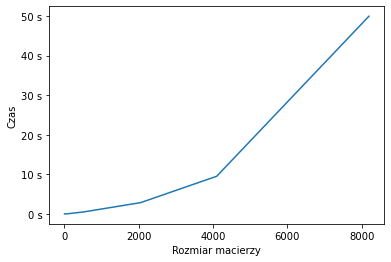

In [101]:
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%d s"))
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas")
plt.plot(powers, times_lu)

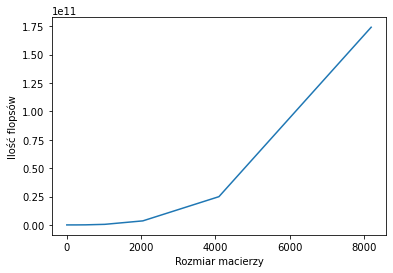

In [102]:
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Ilość flopsów")
plt.plot(powers, flops_lu)

In [107]:
times_determinant: List[float] = []
flops_determinant: List[int] = []

for k in power_basis:
    A = generate_matrix(2**k, 2**k)

    counter = Counter()
    start_time: float = time()

    recursive_determinant(A, counter)

    total_time: float = time() - start_time

    times_determinant.append(total_time)
    flops_determinant.append(counter.operation_counter)

C:\Users\fabia\AppData\Local\Temp\ipykernel_7652\1128701643.py:11: RuntimeWarning: overflow encountered in double_scalars
  det = functools.reduce(lambda x, y: x * y, U_diag)


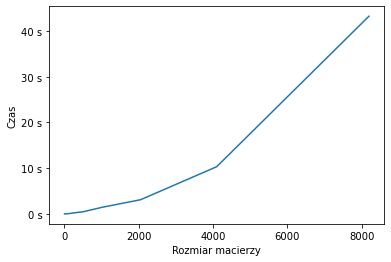

In [125]:
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%d s"))
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas")
plt.plot(powers, times_determinant)

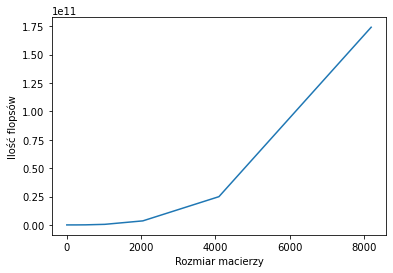

In [126]:
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Ilość flopsów")
plt.plot(powers, flops_determinant)

In [108]:
def generate_matrix(ncols: int, nrows: int):
    return np.random.randint(low=1, high=9, size=(nrows, ncols))

A = generate_matrix(5, 5)
counter = Counter()

In [128]:
import scipy

In [136]:
A = np.array([[1, 8, 5], [2, 4, 6], [3, 5, 7]])
L, U = recursive_lu(A, counter)
L

array([[1.        , 0.        , 0.        ],
       [2.        , 1.        , 0.        ],
       [3.        , 1.58333333, 1.        ]])

In [137]:
U

array([[  1.        ,   8.        ,   5.        ],
       [  0.        , -12.        ,  -4.        ],
       [  0.        ,   0.        ,  -1.66666667]])

In [139]:
A = np.array([[1, 8, 5], [2, 4, 6], [3, 5, 7]])
A = scipy.linalg.lu(A, permute_l=true)
A

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1078, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "c:\Users\fabia\anaconda3\envs\PSI\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "c:\Users\fabia\anaconda3\envs\PSI\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 